# Exploration of PCA for Bias Inspection: HAM10k

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import decomposition
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})
plt.rcParams['figure.dpi'] = 50

In [12]:
# Define constants
alpha = 0.6
style = 'o'
markersize = 40
fontscale = 1.6
color_palette = 'tab10'
kind = 'scatter'
rasterized_scatter = True
out_dpi = 300
out_format = 'png'

In [13]:
MODEL_FEATURES = {
    'resnet18': 512,
    'resnet34': 512,
    'resnet50': 2048,
    'resnet101': 2048,
}

In [14]:
def create_pca(
        embeds_array: np.ndarray,
        model_df: pd.DataFrame
    ):
    
    # n -> number of samples
    # m -> number of features
    n, m = embeds_array.shape
    pca = decomposition.PCA(n_components=0.99, whiten=False)
    embeds_pca = pca.fit_transform(embeds_array)

    mu = pca.mean_
    U = pca.components_.T
    D = pca.singular_values_**2 / (n - 1)
    exp_var = pca.explained_variance_ratio_

    model_df['PCA Mode 1'] = embeds_pca[:,0]
    model_df['PCA Mode 2'] = embeds_pca[:,1]
    model_df['PCA Mode 3'] = embeds_pca[:,2]
    model_df['PCA Mode 4'] = embeds_pca[:,3]

    # Replace numerical labels with categorical
    model_df['Labels'] = model_df['Labels'].replace({0: 'Benign', 1: 'Maglinant'})
    model_df['Sex'] = model_df['Sex'].replace({0: 'Male', 1: 'Female'})
    model_df['Age'] = model_df['Age'].replace({0: '<60', 1: '60+'})

    print('Explained variance')
    print(exp_var[:4])

In [15]:
def plot(
    label: str,
    df: pd.DataFrame,
    hue_order: list[str],
    model_id: str,
    save_dir: str
):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    ### PCA 1 + 2
    x_data = 'PCA Mode 1'
    y_data = 'PCA Mode 2'
    # Scatter with distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig = sns.jointplot(x=x_data, y=y_data, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=hue_order, data=df, joint_kws=dict(rasterized=rasterized_scatter), marginal_kws={'common_norm': False})
    fig.ax_joint.legend(loc='upper right')
    plt.show()
    # plt.savefig(save_dir + 'pca-1+2' + '-' + model_id + '-' + label + '.' + out_format, bbox_inches='tight', dpi=out_dpi)

    # Just distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=x_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.show()
    # plt.savefig(save_dir + 'pca-1' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)

    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=y_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.show()
    # plt.savefig(save_dir + 'pca-2' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)

    ### PCA 3 + 4
    x_data = 'PCA Mode 3'
    y_data = 'PCA Mode 4'
    # Scatter with distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig = sns.jointplot(x=x_data, y=y_data, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=hue_order, data=df, joint_kws=dict(rasterized=rasterized_scatter), marginal_kws={'common_norm': False})
    fig.ax_joint.legend(loc='upper right')
    plt.show()
    # plt.savefig(save_dir + 'pca-3+4' + '-' + model_id + '-' + label + '.' + out_format, bbox_inches='tight', dpi=out_dpi)

    # Just distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=x_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.show()
    # plt.savefig(save_dir + 'pca-3' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)


    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=y_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.show()
    # plt.savefig(save_dir + 'pca-4' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)
  
  

    

In [16]:
def run_statistical_tests(
    df: pd.DataFrame, # model df with PCA columns
    save_dir: str
):
    
    def stats_tests(marginal, samples):
        df_female = samples[samples['Sex'] == 'Female']
        df_male = samples[samples['Sex'] == 'Male']
        df_young = samples[samples['Age'] == '<60']
        df_old = samples[samples['Age'] == '60+']
        df_benign = samples[samples['Labels'] == 'Benign']
        df_maglinant = samples[samples['Labels'] == 'Maglinant']

        res_label = stats.ks_2samp(np.array(df_benign[marginal]), np.array(df_maglinant[marginal]))
        res_age = stats.ks_2samp(np.array(df_young[marginal]), np.array(df_old[marginal]))
        res_sex = stats.ks_2samp(np.array(df_female[marginal]), np.array(df_male[marginal]))

        return [res_label.pvalue, res_sex.pvalue, res_age.pvalue]
    

    pvals_pca1 = stats_tests('PCA Mode 1', df)
    pvals_pca2 = stats_tests('PCA Mode 2', df)
    pvals_pca3 = stats_tests('PCA Mode 3', df)
    pvals_pca4 = stats_tests('PCA Mode 4', df)
    pvals = np.array([pvals_pca1, pvals_pca2, pvals_pca3, pvals_pca4])
    res = multipletests(pvals.flatten(), alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)
    rejected_null_hypothesis = np.array(res[0]).reshape((4,3))
    adjusted_pvals = np.array(res[1]).reshape((4,3))

    index = ['PCA Mode 1', 'PCA Mode 2', 'PCA Mode 3', 'PCA Mode 4']
    columns_hypothesis = ['label_hypoth','sex_hypoth', 'age_hypoth']
    columns_pvalues = ['label_pv', 'sex_pv', 'age_pv']

    df_hypothesis = pd.DataFrame(rejected_null_hypothesis, index=index, columns=columns_hypothesis)
    df_pvalues = pd.DataFrame(adjusted_pvals, index=index, columns=columns_pvalues).round(6)
    df = pd.concat([df_hypothesis, df_pvalues], axis=1)
    display(df)
    # df.to_csv(save_dir + 'pca-stat.csv', index_label='pca_mode')


In [32]:
from scipy.stats import gaussian_kde
from scipy.spatial import distance

def create_sim_table(
    df: pd.DataFrame,
    save_dir: str
):
    
    def js_simlarity(marginal, samples):
        df_female = samples[samples['Sex'] == 'Female']
        df_male = samples[samples['Sex'] == 'Male']
        df_young = samples[samples['Age'] == '<60']
        df_old = samples[samples['Age'] == '60+']
        df_benign = samples[samples['Labels'] == 'Benign']
        df_maglinant = samples[samples['Labels'] == 'Maglinant']

        def get_js_distance(data_1, data_2):
            # Generate an array of 1000 values between the min and max of both datasets. This serve as the range over which PDFs will be estimated
            x = np.linspace(min(np.min(data_1), np.min(data_2)), max(np.max(data_1), np.max(data_2)), num=1000)

            # Compute Univariate Kernel Density Estimate for both datasets
            pdf1 = gaussian_kde(data_1)(x)
            pdf2 = gaussian_kde(data_2)(x)

            # Normalise
            pdf1 /= np.sum(pdf1)
            pdf2 /= np.sum(pdf2)

            # To avoid div by 0
            epsilon = 1e-10
            pdf1 += epsilon
            pdf2 += epsilon

            # Plot the PDFs
            # plt.figure(figsize=(12, 6))
            # plt.plot(x, pdf1, label='PDF of data_1')
            # plt.plot(x, pdf2, label='PDF of data_2')
            # plt.legend()
            # plt.title('Estimated Probability Density Functions')
            # plt.xlabel('Data values')
            # plt.ylabel('Probability density')
            # plt.show()

            return distance.jensenshannon(pdf1, pdf2, base=2)

        sim_label = get_js_distance(df_benign[marginal], df_maglinant[marginal])
        sim_age = get_js_distance(df_young[marginal], df_old[marginal])
        sim_sex = get_js_distance(df_male[marginal], df_female[marginal])

        return [sim_label, sim_sex, sim_age]
    
    sim_pca1 = js_simlarity('PCA Mode 1', df)
    sim_pca2 = js_simlarity('PCA Mode 2', df)
    sim_pca3 = js_simlarity('PCA Mode 3', df)
    sim_pca4 = js_simlarity('PCA Mode 4', df)

    index = ['PCA Mode 1', 'PCA Mode 2', 'PCA Mode 3', 'PCA Mode 4']
    columns = ['label similarity', 'sex similarity', 'age similarity']
    df_sim = pd.DataFrame([sim_pca1, sim_pca2, sim_pca3, sim_pca4], index=index, columns=columns)

    display(df_sim)
    # df_sim.to_csv(save_dir + 'pca-sim.csv', index_label='pca_mode')
    
    


In [33]:
def run_pca_and_save_plots(
    model_id: str,
    model_name: str,
    model_dir: str,
    data_name: str, # chexpert_no_female, chexpert_no_old etc.
    sample: bool = False,
    teacher: bool = False,
):
    # Load Data
    print('\n------------------------')
    print(model_id)
    embeds_data = pd.read_csv(f'{model_dir}/{model_id}/embeds.csv')
    model_df = pd.read_csv(f'{model_dir}/{model_id}/test_predictions.csv')
    embeds = np.array(embeds_data.iloc[:,0:MODEL_FEATURES[model_name]])

    if teacher:
        save_dir = f'teacher_{model_id}/'
    else:
        save_dir = f'{data_name}/{model_id}/'

    create_pca(embeds, model_df)

    if sample:
        n = model_df.groupby('Labels').size().min()
        model_df = model_df.groupby('Labels').sample(n=100, random_state=42)
        # model_df = model_df.sample(frac=0.1)

    print('\n--- Statistical tests')
    run_statistical_tests(model_df, save_dir)

    print('\n--- Similarity table')
    create_sim_table(model_df, save_dir)

    plot(
        label='Labels',
        df=model_df,
        hue_order=['Benign', 'Maglinant'],
        model_id=model_id,
        save_dir=save_dir,
    )

    plot(
        label='Sex',
        df=model_df,
        hue_order=['Male', 'Female'],
        model_id=model_id,
        save_dir=save_dir,
    )

    plot(
        label='Age',
        df=model_df,
        hue_order=['<60', '60+'],
        model_id=model_id,
        save_dir=save_dir,
    )

        

## Fair Teacher - Unfair Students

### Teachers
- name: 'resnet34'
    - random_seed: 46
    - path: '../results/ham10000/resnet/original/'
- name: 'resnet101'
    - random_seed: 42
    - path: '../results/ham10000/resnet/original/'


------------------------
r34-sam1-s46
Explained variance
[0.355463 0.071380 0.057500 0.043598]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True        True        True       0.0  0.020616  0.000000
PCA Mode 2          True        True       False       0.0  0.000025  1.000000
PCA Mode 3          True        True        True       0.0  0.000001  0.000000
PCA Mode 4          True        True        True       0.0  0.000004  0.013323


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.651111        0.106678        0.339555
PCA Mode 2          0.334610        0.152259        0.109563
PCA Mode 3          0.334569        0.184718        0.260897
PCA Mode 4          0.349305        0.170363        0.151215

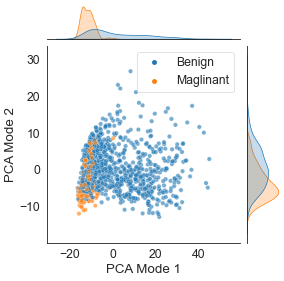

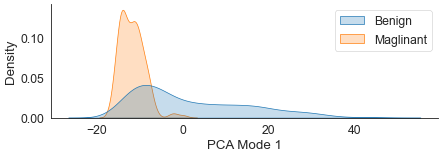

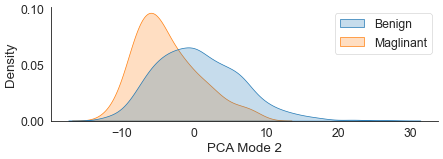

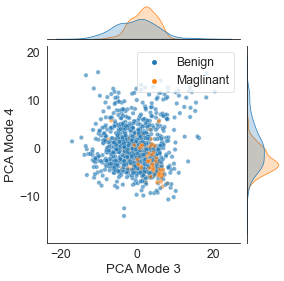

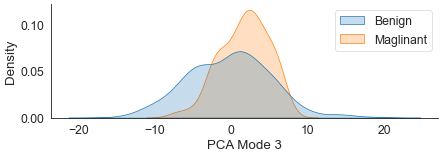

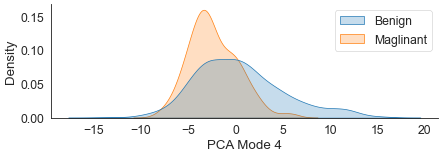

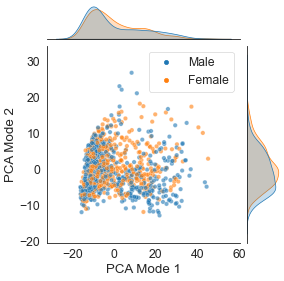

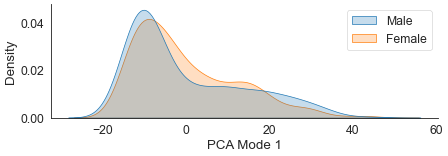

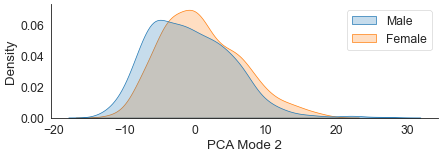

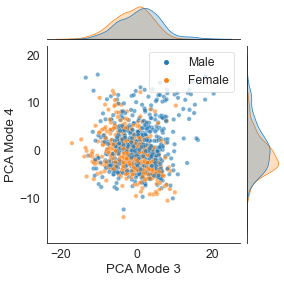

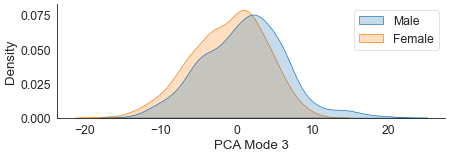

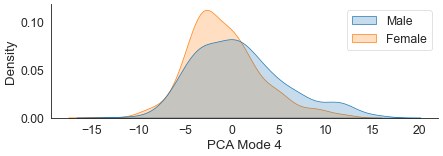

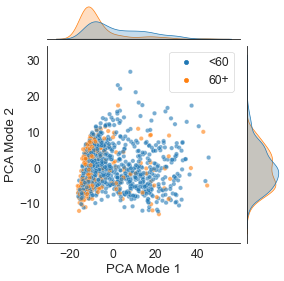

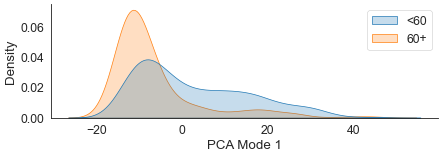

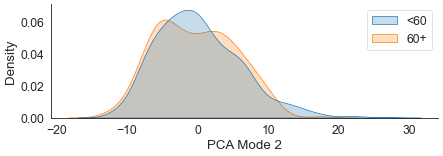

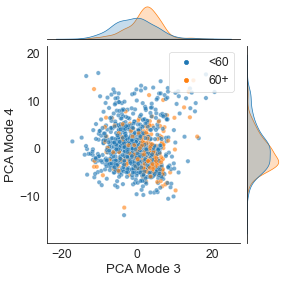

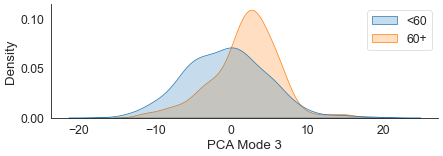

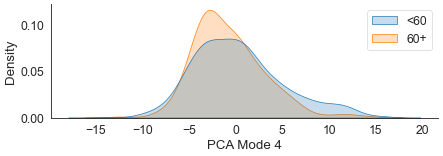

In [34]:
run_pca_and_save_plots(
    model_id='r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000/resnet/original',
    data_name='ham10000',
    sample=False,
    teacher=True,
)

### Students

#### No Female

- models:
    - name: 'resnet18'
    - random_seeds: 
        - 43
        - 46 
    - name: 'resnet34'
    - random_seeds: 
        - 42
        - 43
- path: '../results/ham10000_no_female/resnet/'
- kd_path: '../results/ham10000_no_female/kd/'

##### ResNet18 Student


------------------------
r18-sam1-s46
Explained variance
[0.235007 0.049981 0.047704 0.043364]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True        True        True  0.000000  0.017084  0.000000
PCA Mode 2          True        True        True  0.000002  0.000002  0.000002
PCA Mode 3         False        True        True  0.067793  0.026975  0.005189
PCA Mode 4          True        True        True  0.000000  0.001268  0.000052


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.599224        0.093596        0.358995
PCA Mode 2          0.336041        0.201186        0.222893
PCA Mode 3          0.138552        0.093209        0.117618
PCA Mode 4          0.337470        0.118648        0.171418

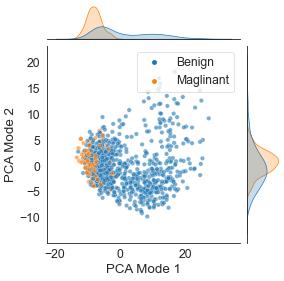

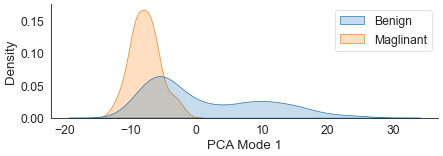

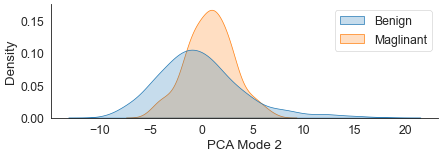

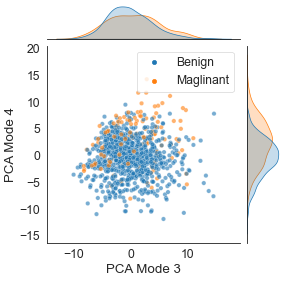

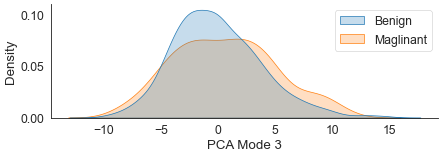

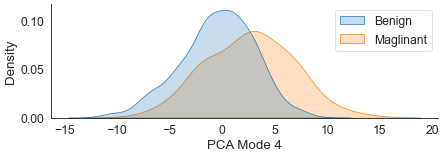

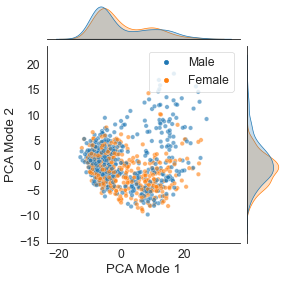

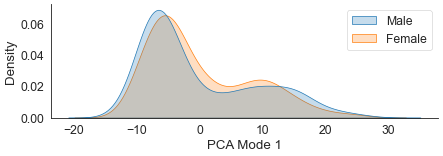

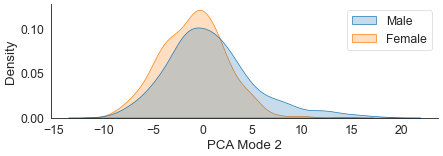

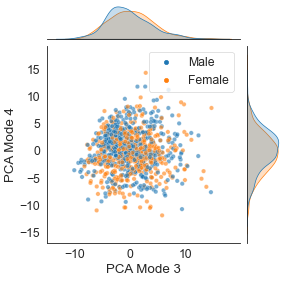

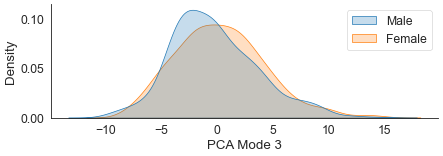

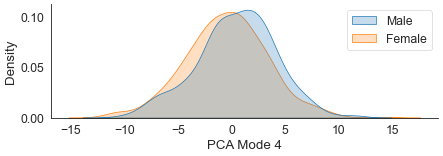

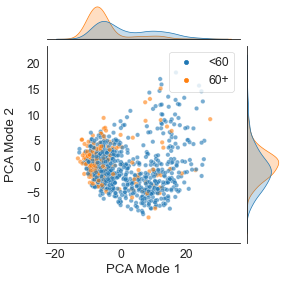

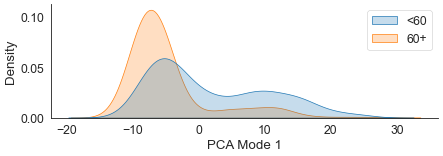

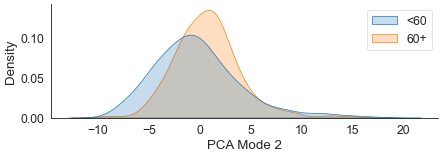

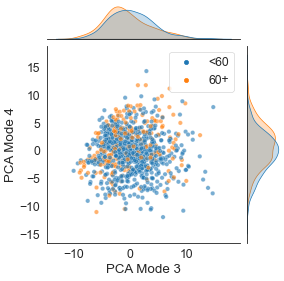

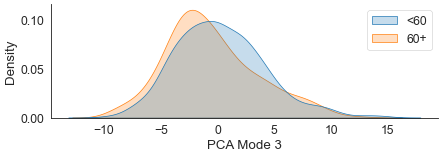

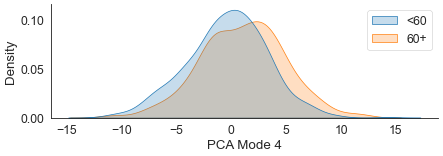


------------------------
r18-sam1-kd1-s46_r34-sam1-s46
Explained variance
[0.475135 0.064375 0.050514 0.029786]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv  age_pv
PCA Mode 1          True        True        True  0.000000  0.000385     0.0
PCA Mode 2          True       False       False  0.000000  0.367926     1.0
PCA Mode 3          True        True        True  0.000025  0.000174     0.0
PCA Mode 4          True       False       False  0.000086  1.000000     1.0


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.629726        0.107497        0.370748
PCA Mode 2          0.350156        0.076380        0.115086
PCA Mode 3          0.259139        0.167240        0.285758
PCA Mode 4          0.227002        0.048805        0.072239

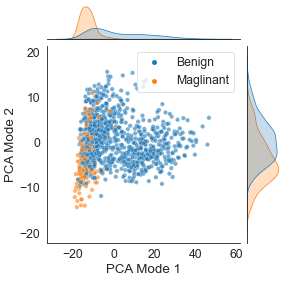

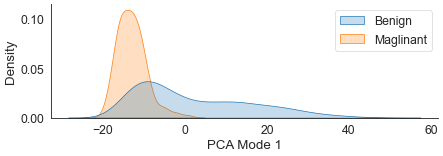

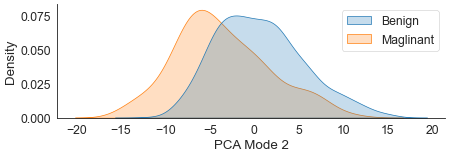

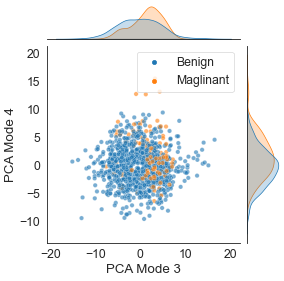

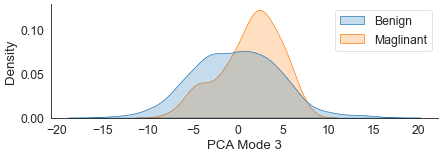

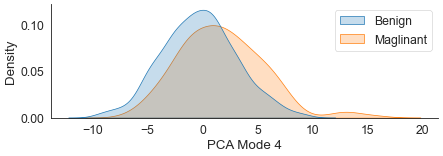

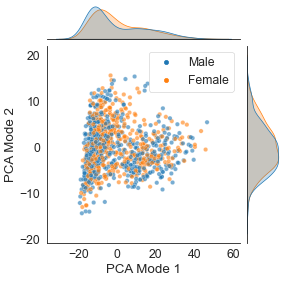

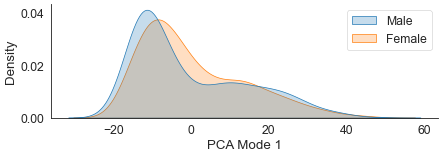

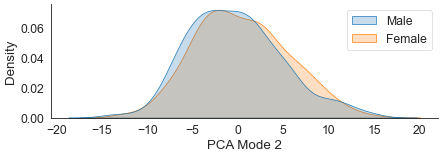

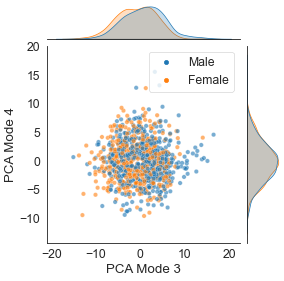

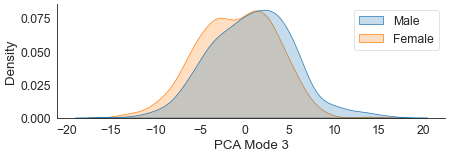

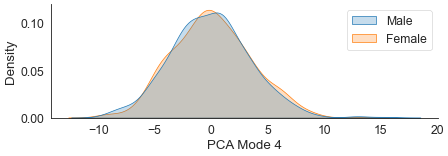

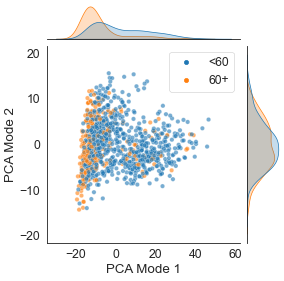

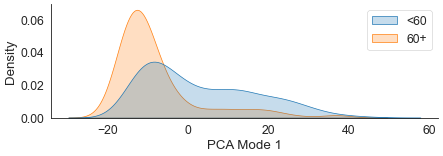

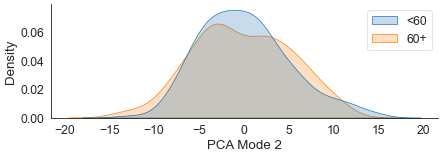

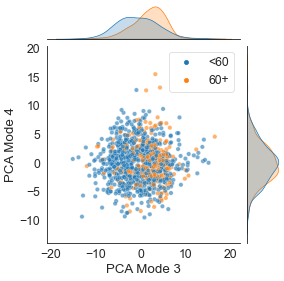

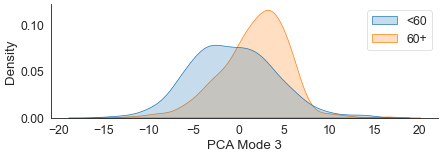

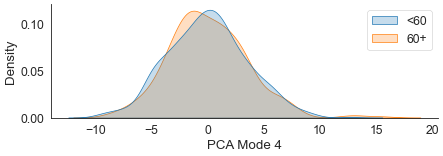

In [20]:
# Resnet18: Seed 46

# Without KD
run_pca_and_save_plots(
    model_id='r18-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_female/resnet',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

# With KD
run_pca_and_save_plots(
    model_id='r18-sam1-kd1-s46_r34-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_female/kd',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

##### Resnet34 Student


------------------------
r34-sam1-s42


Explained variance
[0.335424 0.100835 0.059424 0.032107]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True       False        True  0.000000  0.109262  0.000000
PCA Mode 2          True        True       False  0.000000  0.000192  0.101711
PCA Mode 3         False        True        True  0.277735  0.000006  0.000081
PCA Mode 4         False        True        True  1.000000  0.028310  0.000006


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.593789        0.070552        0.348500
PCA Mode 2          0.326743        0.150611        0.124485
PCA Mode 3          0.111437        0.166550        0.159700
PCA Mode 4          0.084534        0.117386        0.199598

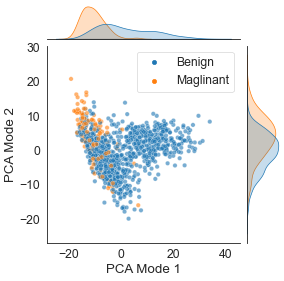

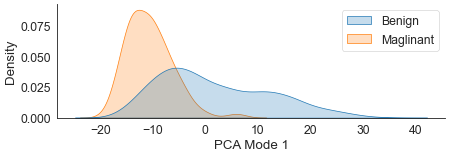

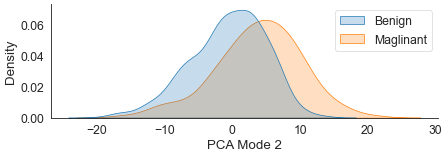

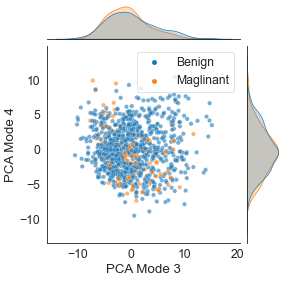

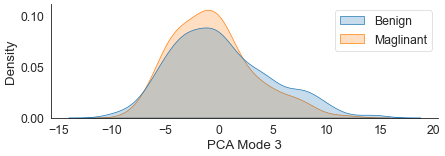

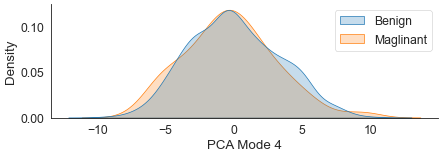

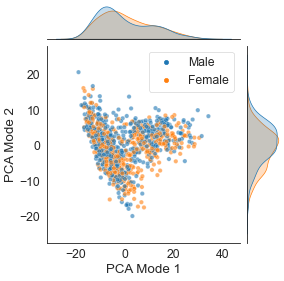

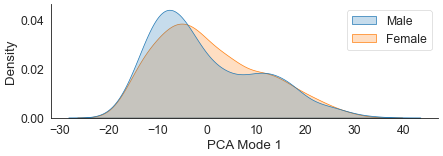

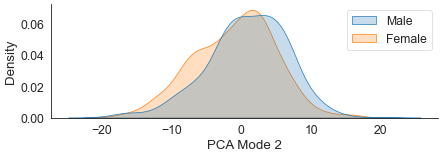

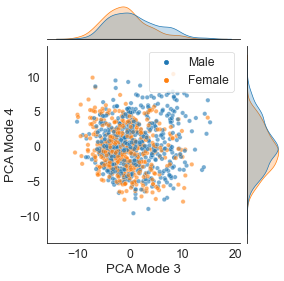

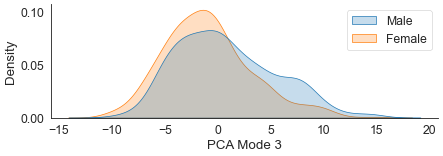

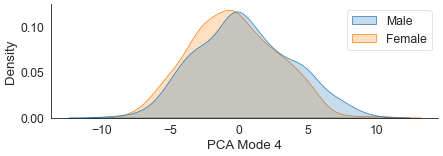

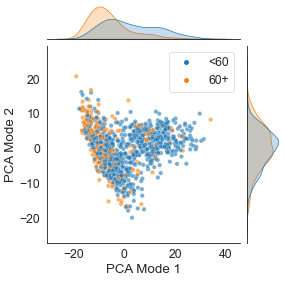

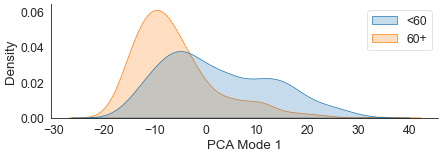

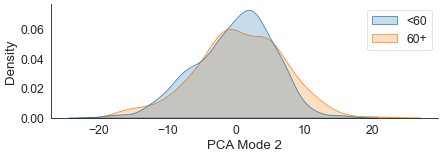

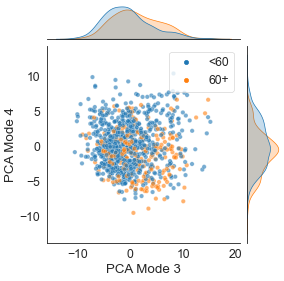

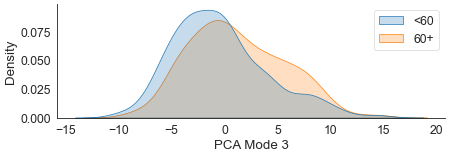

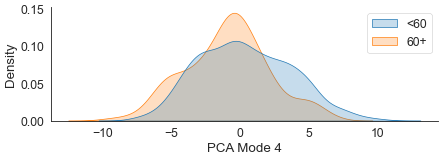


------------------------
r34-sam1-kd1-s42_r34-sam1-s46
Explained variance
[0.461427 0.067719 0.048488 0.040181]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv   age_pv
PCA Mode 1          True        True        True  0.000000  0.002269  0.00000
PCA Mode 2          True        True       False  0.000000  0.000168  0.23602
PCA Mode 3          True       False        True  0.000000  1.000000  0.00000
PCA Mode 4         False        True        True  0.860702  0.000000  0.00000


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.644716        0.102557        0.347178
PCA Mode 2          0.398230        0.130459        0.141581
PCA Mode 3          0.251860        0.049925        0.228460
PCA Mode 4          0.168814        0.230832        0.202500

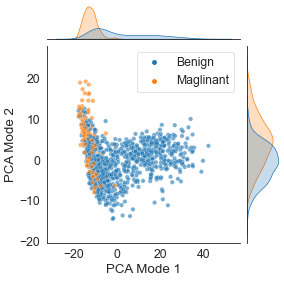

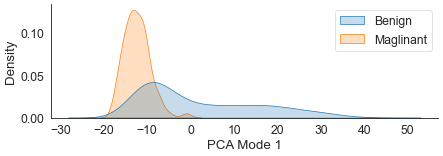

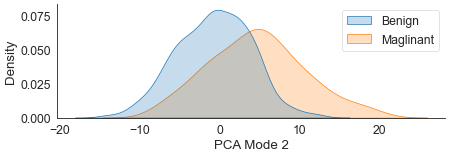

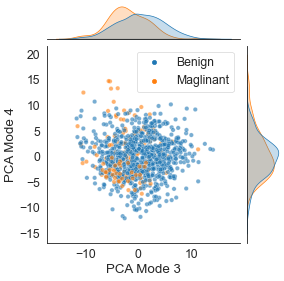

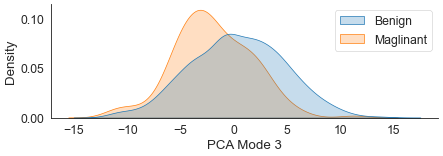

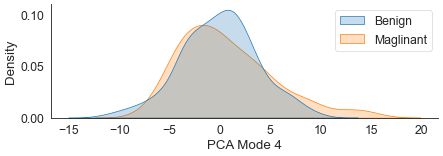

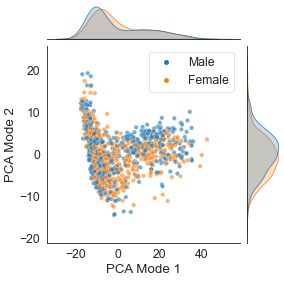

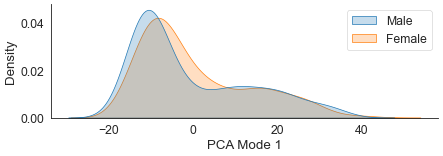

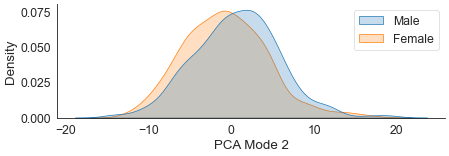

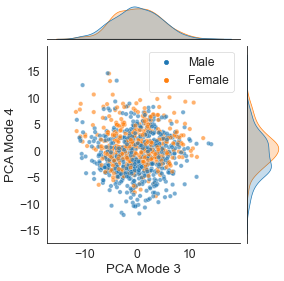

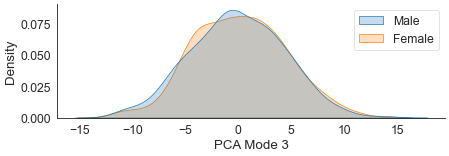

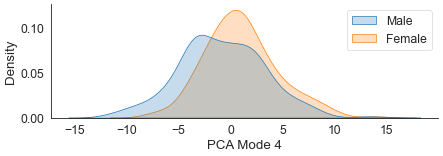

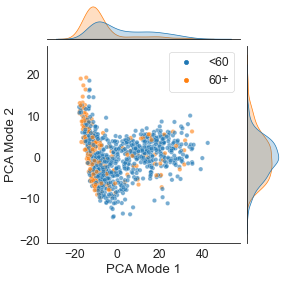

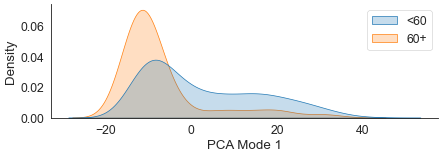

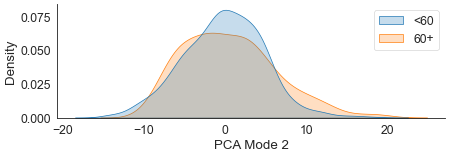

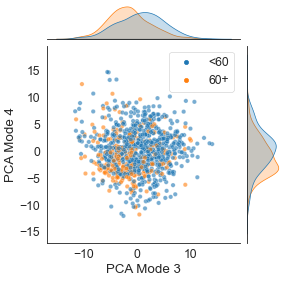

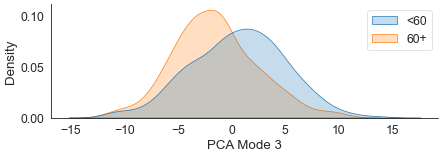

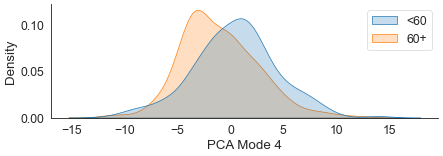

In [21]:
# Resnet34: Seed 42

# Without KD
run_pca_and_save_plots(
    model_id='r34-sam1-s42',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_female/resnet',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

# With KD
run_pca_and_save_plots(
    model_id='r34-sam1-kd1-s42_r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_female/kd',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

#### No Old

- models:
    - name: 'resnet18'
    - random_seeds: 
      - 43
      - 46 
    - name: 'resnet34'
    - random_seeds: 
      - 42
      - 43
- path: '../results/ham10000_no_old/resnet/'
- kd_path: '../results/ham10000_no_old/kd/'

##### Resnet18


------------------------
r18-sam1-s46
Explained variance
[0.216872 0.084462 0.052576 0.038735]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True       False        True  0.000000  0.752712  0.000000
PCA Mode 2         False        True       False  0.270738  0.032658  1.000000
PCA Mode 3         False        True        True  0.072838  0.038632  0.032658
PCA Mode 4         False       False       False  1.000000  1.000000  0.270738


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.587634        0.071452        0.384028
PCA Mode 2          0.143611        0.094767        0.063219
PCA Mode 3          0.148896        0.100617        0.126342
PCA Mode 4          0.122728        0.062026        0.098618

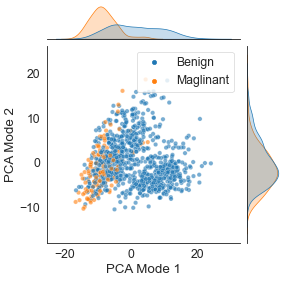

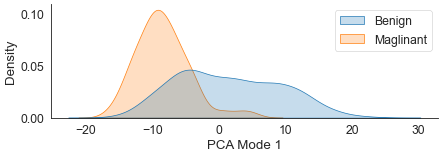

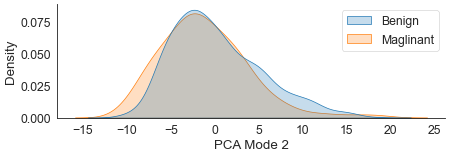

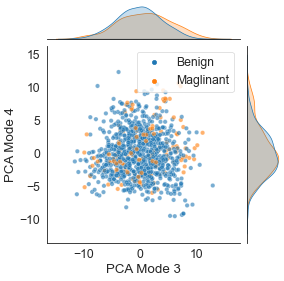

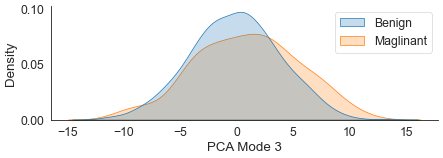

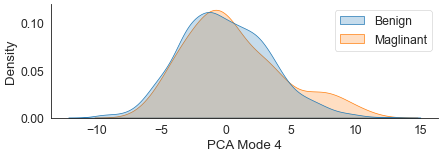

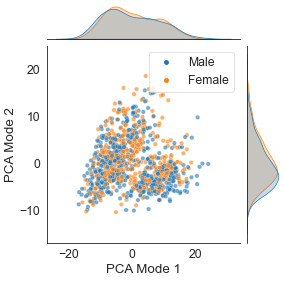

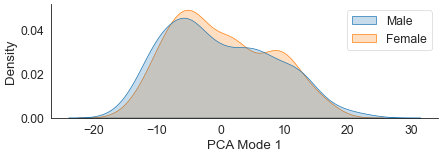

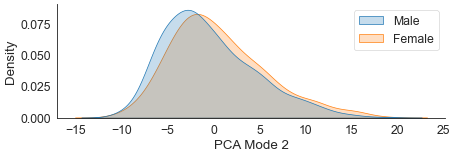

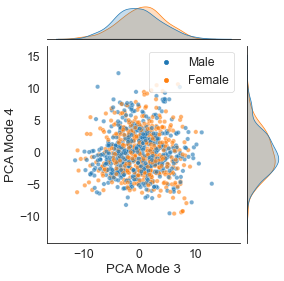

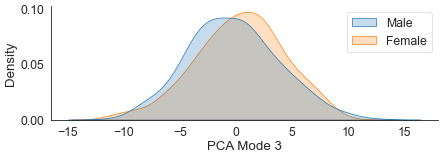

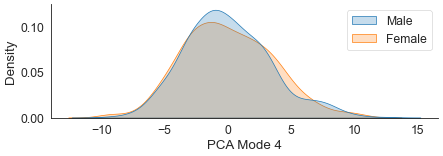

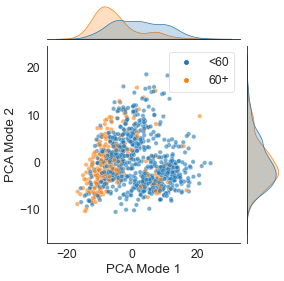

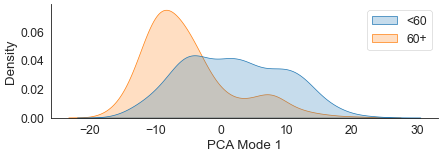

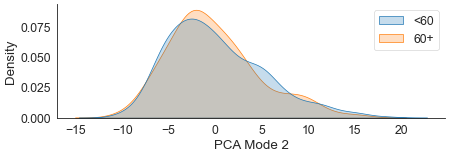

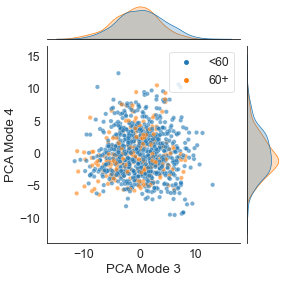

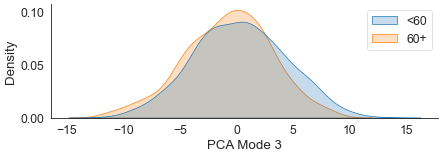

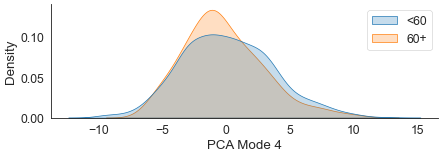


------------------------
r18-sam1-kd1-s46_r34-sam1-s46
Explained variance
[0.371498 0.078052 0.068364 0.035662]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True        True        True  0.000000  0.023155  0.000000
PCA Mode 2          True        True        True  0.000001  0.000001  0.000000
PCA Mode 3          True       False        True  0.000000  1.000000  0.023155
PCA Mode 4          True       False       False  0.000659  0.344518  1.000000


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.629350        0.106697        0.361678
PCA Mode 2          0.255826        0.162947        0.233303
PCA Mode 3          0.332125        0.068520        0.154229
PCA Mode 4          0.203359        0.077199        0.086149

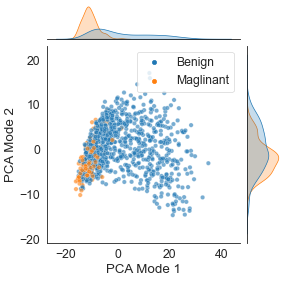

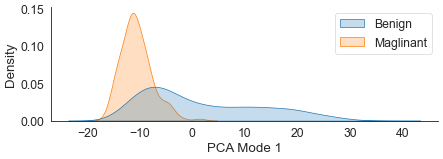

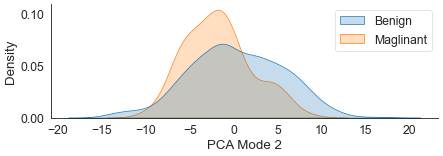

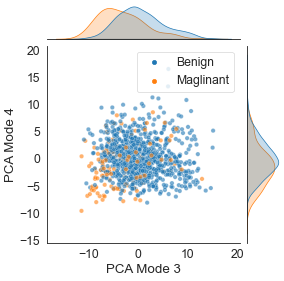

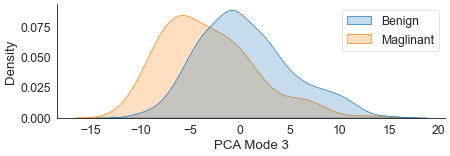

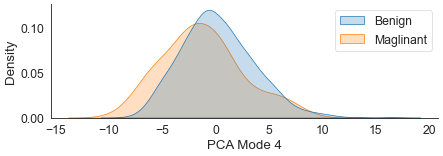

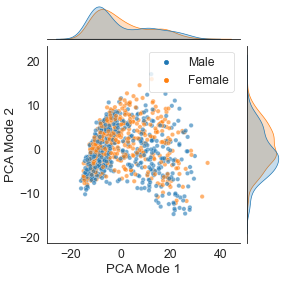

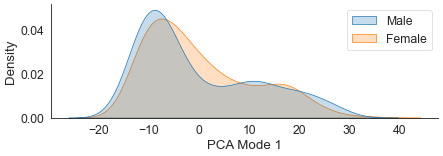

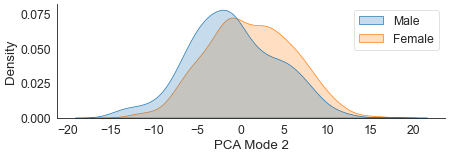

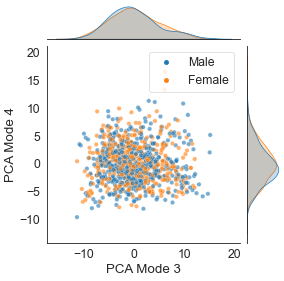

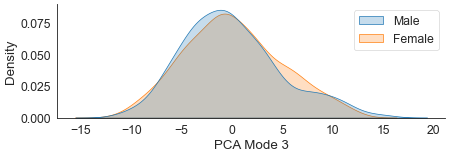

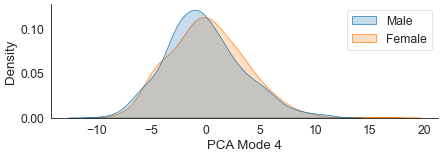

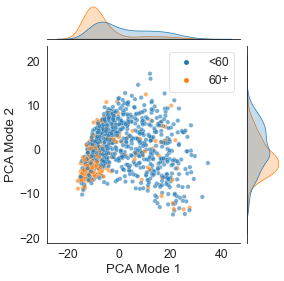

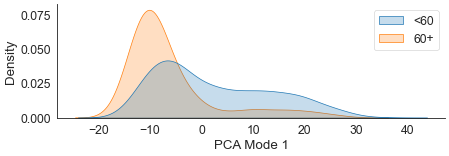

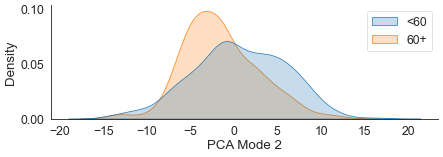

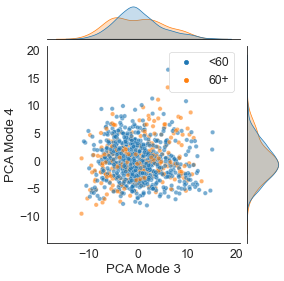

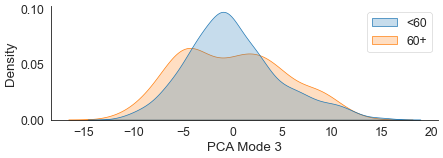

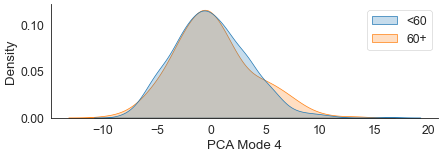

In [22]:
# Resnet18: Seed 46

# Without KD
run_pca_and_save_plots(
    model_id='r18-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_old/resnet',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

# With KD
run_pca_and_save_plots(
    model_id='r18-sam1-kd1-s46_r34-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_old/kd',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

##### Resnet34


------------------------
r34-sam1-s42
Explained variance
[0.266249 0.092409 0.058673 0.039366]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True       False        True  0.000000  0.759626  0.000000
PCA Mode 2          True        True        True  0.000000  0.000555  0.000000
PCA Mode 3         False        True        True  0.050928  0.000000  0.032114
PCA Mode 4          True        True       False  0.000862  0.000367  0.112684


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.507247        0.087614        0.304485
PCA Mode 2          0.323740        0.139822        0.240529
PCA Mode 3          0.219709        0.212180        0.153468
PCA Mode 4          0.278359        0.186896        0.172650

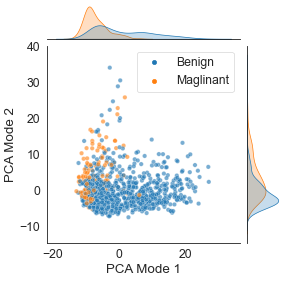

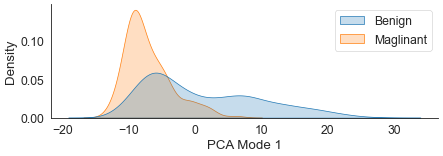

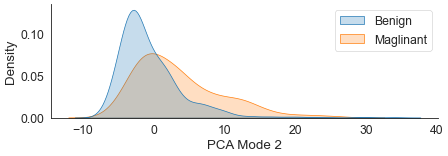

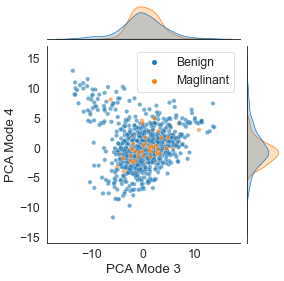

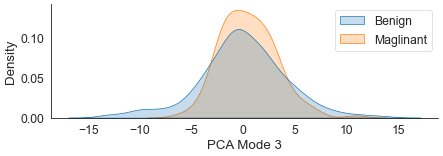

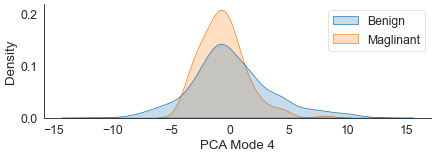

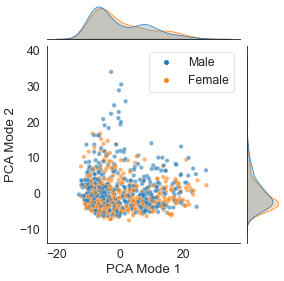

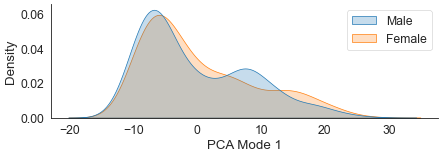

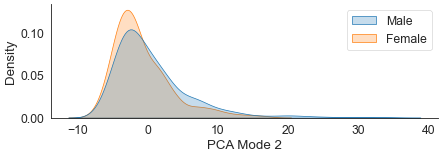

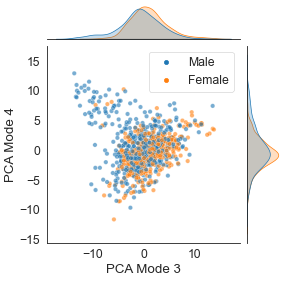

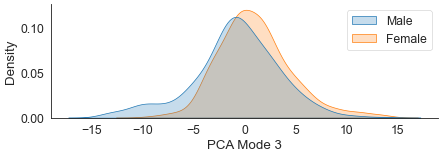

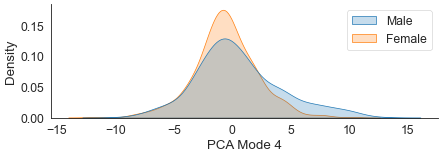

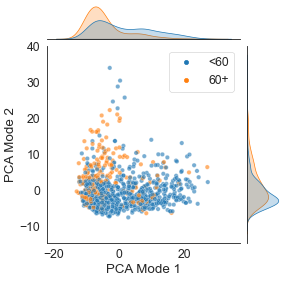

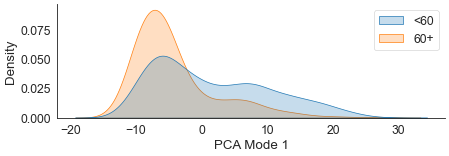

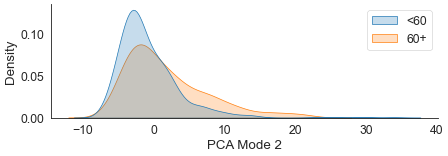

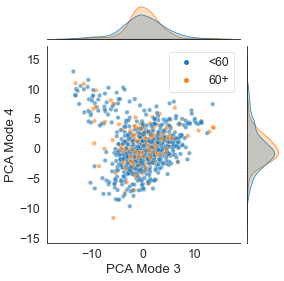

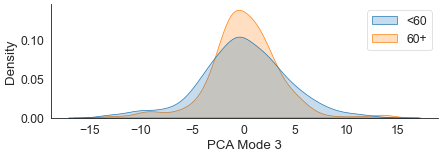

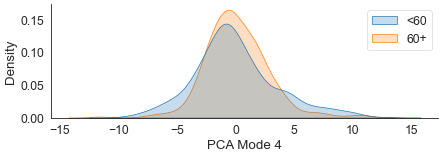


------------------------
r34-sam1-kd1-s42_r34-sam1-s46
Explained variance
[0.402076 0.081094 0.049404 0.039580]

--- Statistical tests


label_hypoth  sex_hypoth  age_hypoth  label_pv    sex_pv    age_pv
PCA Mode 1          True       False        True  0.000000  0.087837  0.000000
PCA Mode 2          True        True        True  0.000000  0.006731  0.003058
PCA Mode 3         False        True        True  0.791845  0.000000  0.000002
PCA Mode 4          True       False        True  0.040618  1.000000  0.000000


--- Similarity table


label similarity  sex similarity  age similarity
PCA Mode 1          0.648597        0.095731        0.364729
PCA Mode 2          0.436688        0.097024        0.174261
PCA Mode 3          0.139143        0.224398        0.183346
PCA Mode 4          0.126810        0.075293        0.200030

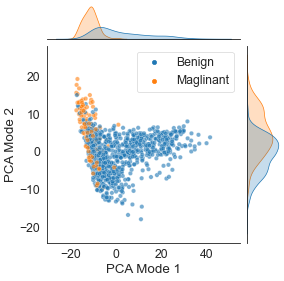

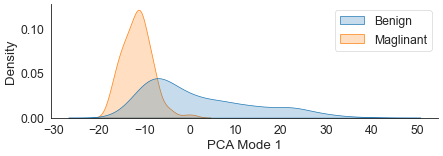

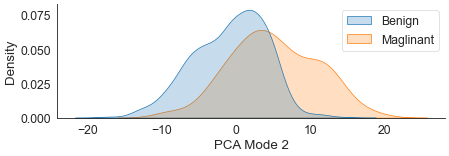

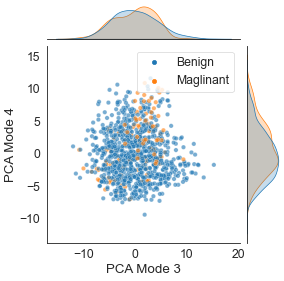

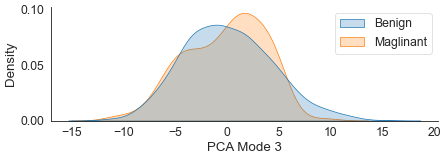

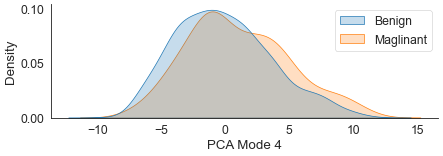

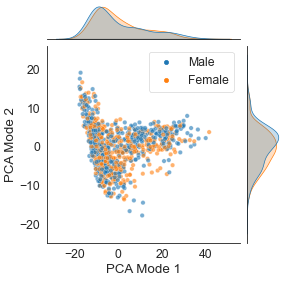

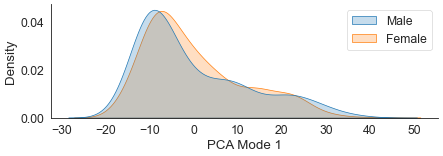

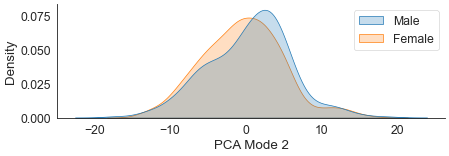

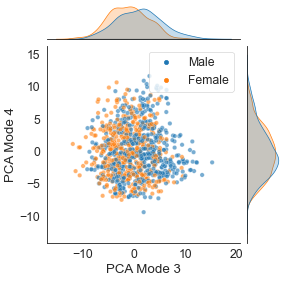

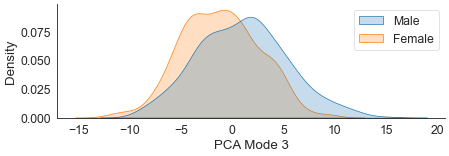

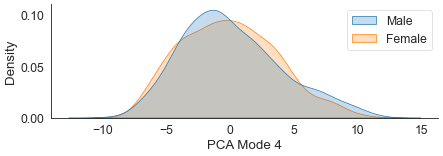

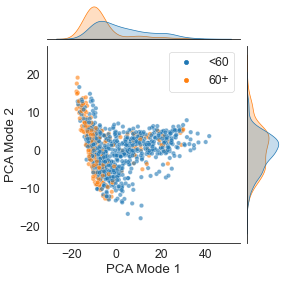

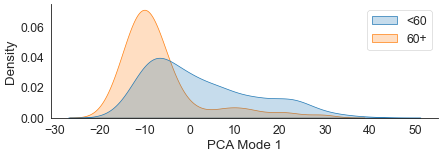

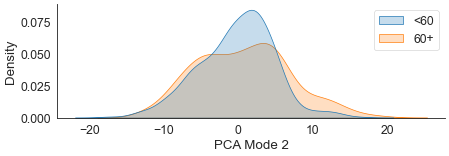

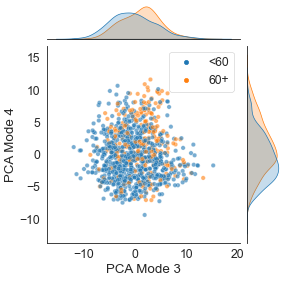

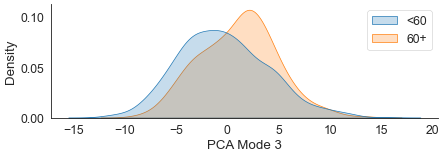

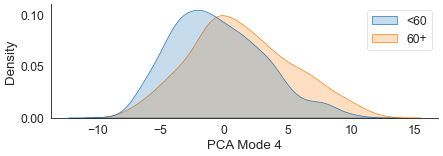

In [23]:
# Resnet18: Seed 46

# Without KD
run_pca_and_save_plots(
    model_id='r34-sam1-s42',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_old/resnet',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

# With KD
run_pca_and_save_plots(
    model_id='r34-sam1-kd1-s42_r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_old/kd',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)